In [1]:
# CatBoost Refinement Notebook

# %% -------------------- Imports and Setup --------------------
import pandas as pd
import numpy as np
import sys
import pathlib
import random
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

# Set seed for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Setup path
project_root = pathlib.Path().resolve().parent
sys.path.append(str(project_root / 'src'))

import util


In [2]:

# %% -------------------- Load and Preprocess Data --------------------
train_df, test_df = util.load_data('../data/train.csv', '../data/test.csv')

# Separate target
target = 'rainfall'
train_y = train_df[target]
train_X = train_df.drop(columns=[target, 'id'])
test_df_no_id = test_df.drop(columns=['id'])

# Preprocess
df_train, df_test = util.preprocess_train_test(train_X, test_df_no_id)
df_test = util.align_columns(df_train, df_test)


Train shape: (2190, 13), Test shape: (730, 12)


In [3]:
# drop column
df_train = df_train.drop(columns=['day', 'temparature'])
df_test = df_test.drop(columns=['day', 'temparature'])

In [4]:

# %% -------------------- Class Imbalance Handling --------------------
pos = sum(train_y == 1)
neg = sum(train_y == 0)
scale_pos_weight = neg / pos
print(f"Scale Pos Weight: {scale_pos_weight:.2f}")
print("Class distribution:\n", train_y.value_counts(normalize=True))


Scale Pos Weight: 0.33
Class distribution:
 rainfall
1    0.753425
0    0.246575
Name: proportion, dtype: float64


In [5]:

# %% -------------------- Optuna Hyperparameter Tuning for CatBoost --------------------
def objective(trial):
    param = {
        'iterations': trial.suggest_int('iterations', 500, 3000),
        'depth': trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1.0),
        'random_strength': trial.suggest_float('random_strength', 0, 1.0),
        'scale_pos_weight': scale_pos_weight,
        'random_seed': SEED,
        'eval_metric': 'AUC',
        'verbose': False
    }
    
    model = CatBoostClassifier(**param)
    scores = cross_val_score(model, df_train, train_y, cv=5, scoring='roc_auc', n_jobs=-1)
    return scores.mean()

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=SEED))
study.optimize(objective, n_trials=200, show_progress_bar=True)

print("\n===== Best Parameters from Optuna =====")
print(study.best_params)


[I 2025-03-11 06:51:18,496] A new study created in memory with name: no-name-9033eb88-91b7-40c9-aafa-0757c1bcaf44


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-03-11 06:52:07,452] Trial 0 finished with value: 0.8838327721661056 and parameters: {'iterations': 1436, 'depth': 10, 'learning_rate': 0.044803926826840625, 'l2_leaf_reg': 6.387926357773329, 'bagging_temperature': 0.15601864044243652, 'random_strength': 0.15599452033620265}. Best is trial 0 with value: 0.8838327721661056.
[I 2025-03-11 06:52:16,714] Trial 1 finished with value: 0.8879685746352413 and parameters: {'iterations': 645, 'depth': 9, 'learning_rate': 0.03027182927734624, 'l2_leaf_reg': 7.372653200164409, 'bagging_temperature': 0.020584494295802447, 'random_strength': 0.9699098521619943}. Best is trial 1 with value: 0.8879685746352413.
[I 2025-03-11 06:52:23,245] Trial 2 finished with value: 0.8844332210998879 and parameters: {'iterations': 2581, 'depth': 4, 'learning_rate': 0.008620446097910767, 'l2_leaf_reg': 2.650640588680904, 'bagging_temperature': 0.3042422429595377, 'random_strength': 0.5247564316322378}. Best is trial 1 with value: 0.8879685746352413.
[I 2025-03

In [6]:

# %% -------------------- Train and Validate with Optimized CatBoost --------------------
X_train, X_val, y_train, y_val = train_test_split(df_train, train_y, test_size=0.2, stratify=train_y, random_state=SEED)

best_cat_model = CatBoostClassifier(**study.best_params, random_seed=SEED, eval_metric='AUC', verbose=False)
best_cat_model.fit(X_train, y_train, eval_set=(X_val, y_val))

# Predict on validation set and print AUC
val_preds = best_cat_model.predict_proba(X_val)[:, 1]
val_auc = roc_auc_score(y_val, val_preds)
print(f"\nFinal Validation AUC (CatBoost Optimized): {val_auc:.4f}")

# %% -------------------- Repeated Stratified CV for AUC Stability --------------------
print("\n===== Repeated Stratified K-Fold AUC Evaluation =====")
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=SEED)
scores = cross_val_score(best_cat_model, df_train, train_y, cv=cv, scoring='roc_auc', n_jobs=-1)
print(f"Mean AUC: {scores.mean():.4f}, Std: {scores.std():.4f}")



Final Validation AUC (CatBoost Optimized): 0.8968

===== Repeated Stratified K-Fold AUC Evaluation =====
Mean AUC: 0.8942, Std: 0.0228


In [7]:

# %% -------------------- Predict on Test and Create Submission --------------------
test_probs = best_cat_model.predict_proba(df_test)[:, 1]

util.write_submission(test_df, test_probs, id_column='id', output_path='submission_catboost_optuna.csv', prediction_column='rainfall')


Submission file written to: submission_catboost_optuna.csv


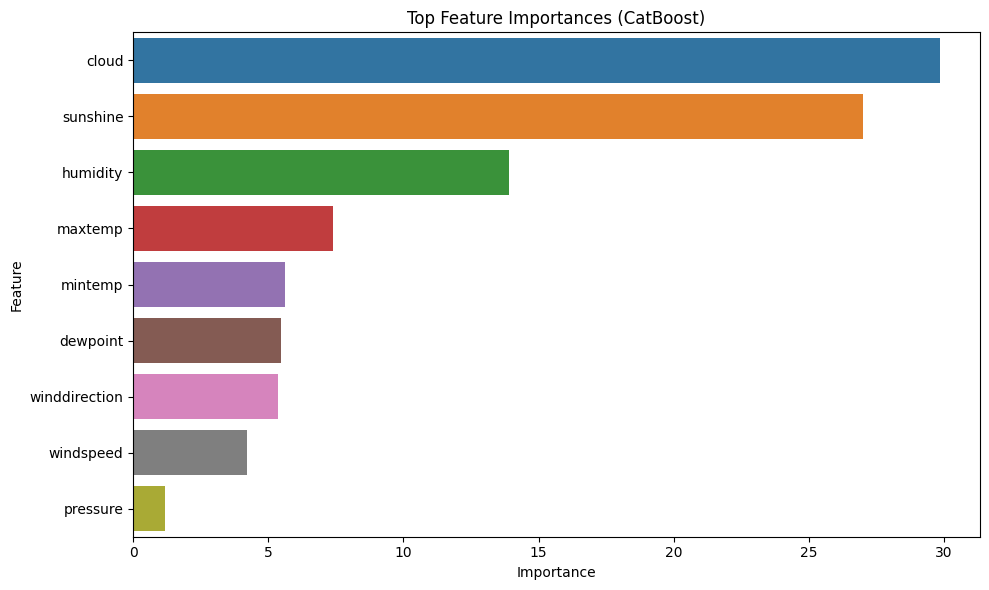

In [8]:

# %% -------------------- Feature Importance Plot --------------------
def plot_feature_importance(model, top_n=20):
    feature_importances = model.get_feature_importance()
    feature_names = df_train.columns
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False).head(top_n)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance_df, x='Importance', y='Feature')
    plt.title('Top Feature Importances (CatBoost)')
    plt.tight_layout()
    plt.show()

plot_feature_importance(best_cat_model)
